## ビールと疑似ビール(第2のビール，第3のビール)を見た目から識別するCNNのプログラム
### sampleコードを少し改変したものとなっています．

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# python2, python3の互換性のためのおまじない
from __future__ import print_function

import six.moves.cPickle as pickle
import numpy
import tensorflow as tf

# jupyterで画像を表示するためのおまじない
%matplotlib inline
import matplotlib.pyplot as plt

### Hyper parameters

In [ ]:
IMAGE_SIZE = 32
NUM_LABELS  =2
BATCH_SIZE = 10
NUM_CHANNELS = 3
N_TRAIN = 500 #659
train_size = N_TRAIN
dataset_dir = './all_imgs_dic.pkl'

### Load dataset and make target labels

In [58]:
dataset = label_data = pickle.load(open(dataset_dir))
rdm = numpy.random.permutation(len(dataset['target']))

train_data = dataset['data'][rdm][:N_TRAIN].astype(numpy.float32)
train_target = dataset['target'][rdm][:N_TRAIN].astype(numpy.int32)
train_labels = []

for t in train_target:
    tmp = [0, 0]
    tmp[t] = 1
    train_labels.append(tmp)
train_labels = numpy.array(train_labels)

test_data = dataset['data'][rdm][N_TRAIN:].astype(numpy.float32)
test_target = dataset['target'][rdm][N_TRAIN:].astype(numpy.int32)
test_labels = []

for t in test_target:
    tmp = [0, 0]
    tmp[t] = 1
    test_labels.append(tmp)
test_labels = numpy.array(test_labels)

print("train_data:{}, train_target:{}, test_data:{}, test_target:{}".format(
        train_data.shape, train_labels.shape, test_data.shape, test_labels.shape))

train_data:(500, 32, 32, 3), train_target:(500, 2), test_data:(159, 32, 32, 3), test_target:(159, 2)


In [59]:
# We'll bundle groups of examples during training for efficiency.
# This defines the size of the batch.
# We have only one channel in our grayscale images.
# The random seed that defines initialization.
SEED = 42

# This is where training samples and labels are fed to the graph.
# These placeholder nodes will be fed a batch of training data at each
# training step, which we'll write once we define the graph structure.
train_data_node = tf.placeholder(
  tf.float32,
  shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS))
train_labels_node = tf.placeholder(tf.float32,
                                   shape=(BATCH_SIZE, NUM_LABELS))

# For the validation and test data, we'll just hold the entire dataset in
# one constant node.
#validation_data_node = tf.constant(validation_data)
test_data_node = tf.constant(test_data)

# The variables below hold all the trainable weights. For each, the
# parameter defines how the variables will be initialized.
conv1_weights = tf.Variable(
  tf.truncated_normal([5, 5, NUM_CHANNELS, 16],  # 5x5 filter, depth 32.
                      stddev=0.1,
                      seed=SEED))
conv1_biases = tf.Variable(tf.zeros([16]))
conv2_weights = tf.Variable(
  tf.truncated_normal([5, 5, 16, 32],
                      stddev=0.1,
                      seed=SEED))
conv2_biases = tf.Variable(tf.constant(0.1, shape=[32]))
conv3_weights = tf.Variable(
  tf.truncated_normal([5, 5, 32, 64],
                      stddev=0.1,
                      seed=SEED))
conv3_biases = tf.Variable(tf.constant(0.1, shape=[64]))

fc_weights = tf.Variable(
  tf.truncated_normal([IMAGE_SIZE // 8 * IMAGE_SIZE // 8 * 64, NUM_LABELS],
                      stddev=0.1,
                      seed=SEED))
fc_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))

#fc1_weights = tf.Variable(  # fully connected, depth 512.
#  tf.truncated_normal([IMAGE_SIZE // 8 * IMAGE_SIZE // 8 * 64, 512],
#                      stddev=0.1,
#                      seed=SEED))
#fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))
#fc2_weights = tf.Variable(
#  tf.truncated_normal([512, NUM_LABELS],
#                      stddev=0.1,
#                      seed=SEED))
#fc2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]))

print('Done')

Done


Now that we've defined the variables to be trained, we're ready to wire them together into a TensorFlow graph.

We'll define a helper to do this, `model`, which will return copies of the graph suitable for training and testing. Note the `train` argument, which controls whether or not dropout is used in the hidden layer. (We want to use dropout only during training.)

In [60]:
def model(data, train=False):
    """The Model definition."""
    # 2D convolution, with 'SAME' padding (i.e. the output feature map has
    # the same size as the input). Note that {strides} is a 4D array whose
    # shape matches the data layout: [image index, y, x, depth].
    conv = tf.nn.conv2d(data,
                        conv1_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')

    # Bias and rectified linear non-linearity.
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv1_biases))

    # Max pooling. The kernel size spec ksize also follows the layout of
    # the data. Here we have a pooling window of 2, and a stride of 2.
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv2_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv2_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool,
                        conv3_weights,
                        strides=[1, 1, 1, 1],
                        padding='SAME')
    relu = tf.nn.relu(tf.nn.bias_add(conv, conv3_biases))
    pool = tf.nn.max_pool(relu,
                          ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

    # Reshape the feature map cuboid into a 2D matrix to feed it to the
    # fully connected layers.
    pool_shape = pool.get_shape().as_list()
    reshape = tf.reshape(
        pool,
        [pool_shape[0], pool_shape[1] * pool_shape[2] * pool_shape[3]])
  
    return tf.matmul(reshape, fc_weights) + fc_biases

    # Fully connected layer. Note that the '+' operation automatically
    # broadcasts the biases.
    #hidden = tf.nn.relu(tf.matmul(reshape, fc1_weights) + fc1_biases)

    # Add a 50% dropout during training only. Dropout also scales
    # activations such that no rescaling is needed at evaluation time.
    #if train:
    #    hidden = tf.nn.dropout(hidden, 0.5, seed=SEED)
    #return tf.matmul(hidden, fc2_weights) + fc2_biases

print('Done')

Done


In [61]:
# Training computation: logits + cross-entropy loss.
logits = model(train_data_node, True)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
  logits, train_labels_node))

# L2 regularization for the fully connected parameters.
#regularizers = (tf.nn.l2_loss(fc1_weights) + tf.nn.l2_loss(fc1_biases) +
#                tf.nn.l2_loss(fc2_weights) + tf.nn.l2_loss(fc2_biases))
regularizers = (tf.nn.l2_loss(fc_weights) + tf.nn.l2_loss(fc_biases))
# Add the regularization term to the loss.
loss += 5e-4 * regularizers

# Optimizer: set up a variable that's incremented once per batch and
# controls the learning rate decay.
batch = tf.Variable(0)
# Decay once per epoch, using an exponential schedule starting at 0.01.
learning_rate = tf.train.exponential_decay(
  0.01,                # Base learning rate.
  batch * BATCH_SIZE,  # Current index into the dataset.
  train_size,          # Decay step.
  0.95,                # Decay rate.
  staircase=True)
# Use simple momentum for the optimization.
optimizer = tf.train.MomentumOptimizer(learning_rate,
                                       0.9).minimize(loss,
                                                     global_step=batch)

# Predictions for the minibatch, validation set and test set.
train_prediction = tf.nn.softmax(logits)
# We'll compute them only once in a while by calling their {eval()} method.
#validation_prediction = tf.nn.softmax(model(validation_data_node))
test_prediction = tf.nn.softmax(model(test_data_node))

print('Done')

Done


In [62]:
# Create a new interactive session that we'll use in
# subsequent code cells.
s = tf.InteractiveSession()

# Use our newly created session as the default for 
# subsequent operations.
s.as_default()

# Initialize all the variables we defined above.
tf.initialize_all_variables().run()

In [63]:
#BATCH_SIZE = 60

# Grab the first BATCH_SIZE examples and labels.
batch_data = train_data[:BATCH_SIZE, :, :, :]
batch_labels = train_labels[:BATCH_SIZE]

# This dictionary maps the batch data (as a numpy array) to the
# node in the graph it should be fed to.
feed_dict = {train_data_node: batch_data,
             train_labels_node: batch_labels}

# Run the graph and fetch some of the nodes.
_, l, lr, predictions = s.run(
  [optimizer, loss, learning_rate, train_prediction],
  feed_dict=feed_dict)

print('Done')

Done


In [64]:
def error_rate(predictions, labels):
    """Return the error rate and confusions."""
    correct = numpy.sum(numpy.argmax(predictions, 1) == numpy.argmax(labels, 1))
    total = predictions.shape[0]

    error = 100.0 - (100 * float(correct) / float(total))

    confusions = numpy.zeros([10, 10], numpy.float32)
    bundled = zip(numpy.argmax(predictions, 1), numpy.argmax(labels, 1))
    for predicted, actual in bundled:
        confusions[predicted, actual] += 1
    
    return error, confusions

print('Done')

Done


In [65]:
# Train over the first 1/4th of our training set.
steps = train_size // BATCH_SIZE
for k in range(50):
    for step in range(steps):
        # Compute the offset of the current minibatch in the data.
        # Note that we could use better randomization across epochs.
        offset = (step * BATCH_SIZE) % (train_size - BATCH_SIZE)
        batch_data = train_data[offset:(offset + BATCH_SIZE), :, :, :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
        # This dictionary maps the batch data (as a numpy array) to the
        # node in the graph it should be fed to.
        feed_dict = {train_data_node: batch_data,
                     train_labels_node: batch_labels}
        # Run the graph and fetch some of the nodes.
        _, l, lr, predictions = s.run(
          [optimizer, loss, learning_rate, train_prediction],
          feed_dict=feed_dict)

        # Print out the loss periodically.
        if step % 100 == 0:
            error, _ = error_rate(predictions, batch_labels)
            print('Step %d of %d' % (step, steps))
            print('Mini-batch loss: %.5f Error: %.5f Learning rate: %.5f' % (l, error, lr))
            #print('Validation error: %.1f%%' % error_rate(
            #      validation_prediction.eval(), validation_labels)[0])


Step 0 of 50
Mini-batch loss: 5.95364 Error: 30.00000 Learning rate: 0.01000
Step 0 of 50
Mini-batch loss: 0.65165 Error: 30.00000 Learning rate: 0.00950
Step 0 of 50
Mini-batch loss: 0.59192 Error: 30.00000 Learning rate: 0.00902
Step 0 of 50
Mini-batch loss: 0.57816 Error: 20.00000 Learning rate: 0.00857
Step 0 of 50
Mini-batch loss: 0.38540 Error: 10.00000 Learning rate: 0.00815
Step 0 of 50
Mini-batch loss: 0.40465 Error: 10.00000 Learning rate: 0.00774
Step 0 of 50
Mini-batch loss: 0.38453 Error: 20.00000 Learning rate: 0.00735
Step 0 of 50
Mini-batch loss: 0.36566 Error: 10.00000 Learning rate: 0.00698
Step 0 of 50
Mini-batch loss: 0.21965 Error: 0.00000 Learning rate: 0.00663
Step 0 of 50
Mini-batch loss: 0.15816 Error: 0.00000 Learning rate: 0.00630
Step 0 of 50
Mini-batch loss: 0.05291 Error: 0.00000 Learning rate: 0.00599
Step 0 of 50
Mini-batch loss: 0.05349 Error: 0.00000 Learning rate: 0.00569
Step 0 of 50
Mini-batch loss: 0.01658 Error: 0.00000 Learning rate: 0.00540
Step

Test error: 10.1%


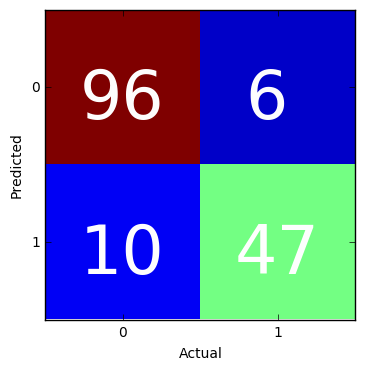

In [68]:
test_error, confusions = error_rate(test_prediction.eval(), test_labels)
print('Test error: %.1f%%' % test_error)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(False)
plt.xticks(numpy.arange(NUM_LABELS))
plt.yticks(numpy.arange(NUM_LABELS))
plt.imshow(confusions, cmap=plt.cm.jet, interpolation='nearest');

plt.xlim([-0.5, 1.5])
plt.ylim([1.5, -0.5])

for i, cas in enumerate(confusions):
    for j, count in enumerate(cas):
        if count > 0:
            xoff = .07 * len(str(count))
            plt.text(j-xoff, i+.2, int(count), fontsize=48, color='white')

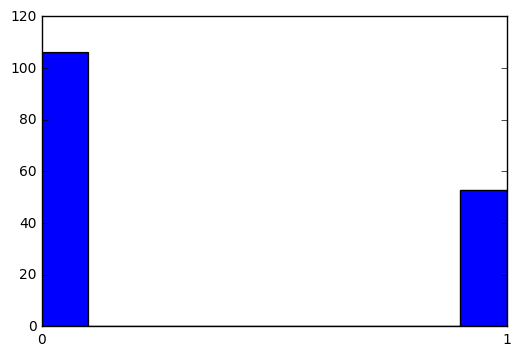

In [69]:
plt.xticks(numpy.arange(NUM_LABELS))
plt.xlim([0, 1])
plt.hist(numpy.argmax(test_labels, 1));